In [16]:
from torch import nn
import torch
from torch import tensor 
from torch.autograd import Variable
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
from pytorch_tabnet.tab_model import TabNetClassifier, TabNetRegressor
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold
import torch
import itertools
from pytorch_tabnet.tab_model import TabNetClassifier
from sklearn.metrics import roc_auc_score, accuracy_score
from tqdm.notebook import tqdm
from pathlib import Path
import os

dataset_name = 'sstfMRI'
train_out = Path(os.getcwd()+'/data1/Suicidalideation_'+dataset_name+'_train.csv')
test_out =Path(os.getcwd()+'/data1/Suicidalideation_'+dataset_name+'_test.csv')


train_data= pd.read_csv(train_out)
test_data= pd.read_csv(test_out)
target ='Suicidalideation.x'
unused_feat = ['Set', 'subjectkey', 'abcd_site.x', 'Unnamed: 0', 'kflod',
               'src_subject_id','interview_date','gender','eventname']
n=0
start_mri = 0;
for i in test_data.columns:
    #print(i)
    if i =='tfmri_sst_all_correct.go.vs.fixation_beta_cort.destrieux_g.and.s.frontomargin.lh':
        start_mri =n
    n +=1

    
mri = list(test_data.columns[start_mri:])
print(mri)
Num_FOLDS  = 5
# the number of feature that you want to show 
Num_feat = 20

['tfmri_sst_all_correct.go.vs.fixation_beta_cort.destrieux_g.and.s.frontomargin.lh', 'tfmri_sst_all_correct.go.vs.fixation_beta_cort.destrieux_g.and.s.occipital.inf.lh', 'tfmri_sst_all_correct.go.vs.fixation_beta_cort.destrieux_g.and.s.paracentral.lh', 'tfmri_sst_all_correct.go.vs.fixation_beta_cort.destrieux_g.and.s.subcentral.lh', 'tfmri_sst_all_correct.go.vs.fixation_beta_cort.destrieux_g.and.s.transv.frontopol.lh', 'tfmri_sst_all_correct.go.vs.fixation_beta_cort.destrieux_g.and.s.cingul.ant.lh', 'tfmri_sst_all_correct.go.vs.fixation_beta_cort.destrieux_g.and.s.cingul.mid.ant.lh', 'tfmri_sst_all_correct.go.vs.fixation_beta_cort.destrieux_g.and.s.cingul.mid.post.lh', 'tfmri_sst_all_correct.go.vs.fixation_beta_cort.destrieux_g.cingul.post.dorsal.lh', 'tfmri_sst_all_correct.go.vs.fixation_beta_cort.destrieux_g.cingul.post.ventral.lh', 'tfmri_sst_all_correct.go.vs.fixation_beta_cort.destrieux_g.cuneus.lh', 'tfmri_sst_all_correct.go.vs.fixation_beta_cort.destrieux_g.front.inf.opercular.l

In [17]:
mri


['tfmri_sst_all_correct.go.vs.fixation_beta_cort.destrieux_g.and.s.frontomargin.lh',
 'tfmri_sst_all_correct.go.vs.fixation_beta_cort.destrieux_g.and.s.occipital.inf.lh',
 'tfmri_sst_all_correct.go.vs.fixation_beta_cort.destrieux_g.and.s.paracentral.lh',
 'tfmri_sst_all_correct.go.vs.fixation_beta_cort.destrieux_g.and.s.subcentral.lh',
 'tfmri_sst_all_correct.go.vs.fixation_beta_cort.destrieux_g.and.s.transv.frontopol.lh',
 'tfmri_sst_all_correct.go.vs.fixation_beta_cort.destrieux_g.and.s.cingul.ant.lh',
 'tfmri_sst_all_correct.go.vs.fixation_beta_cort.destrieux_g.and.s.cingul.mid.ant.lh',
 'tfmri_sst_all_correct.go.vs.fixation_beta_cort.destrieux_g.and.s.cingul.mid.post.lh',
 'tfmri_sst_all_correct.go.vs.fixation_beta_cort.destrieux_g.cingul.post.dorsal.lh',
 'tfmri_sst_all_correct.go.vs.fixation_beta_cort.destrieux_g.cingul.post.ventral.lh',
 'tfmri_sst_all_correct.go.vs.fixation_beta_cort.destrieux_g.cuneus.lh',
 'tfmri_sst_all_correct.go.vs.fixation_beta_cort.destrieux_g.front.inf.

In [18]:
train_data_processed = train_data.fillna(0).reset_index(drop=True)
features = [ col for col in train_data_processed.columns if col not in unused_feat + [target] + mri] 

object_feat =[]

j=0
for i in test_data[features].dtypes:
    #print(j)
    if i == 'object':
        print(test_data[features].columns[j])
        object_feat.append(test_data[features].columns[j])
    j+=1
    
print(object_feat)

features = [ col for col in train_data_processed.columns if col not in unused_feat + [target] +mri +object_feat] 


[]


In [19]:
def preproecessing (train_data, test_data, NUM_FOLDS):
    test_data_processed= test_data.fillna(0).reset_index(drop=True)
    train_data_processed = train_data.fillna(0).reset_index(drop=True)
    
    test_data_processed["kfold"] = -1

    train_data_processed["kfold"] = -1

    train_data_processed = train_data_processed.sample(frac=1,random_state=2020).reset_index(drop=True)

    kf = KFold(n_splits=NUM_FOLDS)

    for fold, (trn_, val_) in enumerate(kf.split(X=train_data_processed, y=train_data_processed)):
        train_data_processed.loc[val_, 'kfold'] = fold
    print("done preprocessing")
    return train_data_processed, test_data_processed

def rocvis(true , prob , label ) :
    from sklearn.metrics import roc_curve
    if type(true[0]) == str :
        from sklearn.preprocessing import LabelEncoder
        le = LabelEncoder()
        true = le.fit_transform(true)
    else :
        pass
    fpr, tpr, thresholds = roc_curve(true, prob)
    plt.plot(fpr, tpr, marker='.', label = label  )
    
# Augmented
import torch
import itertools
from pytorch_tabnet.tab_model import TabNetClassifier
from sklearn.metrics import roc_auc_score, accuracy_score
from tqdm.notebook import tqdm

def feature(Num_feat, clf, test_data_processed, features):
    importance =clf.feature_importances_
    #plt.plot(importance)
    #plt.show()
    labels_importance=importance.argsort()[::-1]

    importance_sort = np.sort(importance)[::-1]

    feat_name_sort=test_data_processed[features].columns[labels_importance]
    important_features = pd.DataFrame() 


    for i in range (Num_feat):
        feature = pd.DataFrame([[feat_name_sort[i],importance_sort[i]]], columns = ['feature name', 'ratio'])
        important_features=pd.concat([important_features,feature])

    return important_features.reset_index(drop=True)

def find_bestpar(X_train, Y_train, X_valid, Y_valid, X_test, Y_test):
    # Store maximum auc
    max_auc= 0
    # Store maximum hypterparameter set
    max_hy = []
    # define hyperparameter space
    """
    n_ = [4,8,16]
    lr_ = [2e-2, 1e-2, 5e-3, 2e-3, 1e-3, 1e-4]
    w_ = [0.01, 0.001, 0.0001]
    g_ = [0.95, 0.99, 0.9]
    ss_ = [10, 20, 30]
    # Orginal hyperparameter space 
    """
    # define hyperparameter space (quick version)
    n_ = [4,8]
    lr_ = [2e-2,1e-2, 5e-3, 2e-3, 1e-3, 1e-4]
    w_ = [0.01, 0.001, 0.0001]
    g_ = [0.95, 0.99]
    ss_ = [10, 20]
  
    all_ = [n_, lr_, w_, g_, ss_]
    h_space = [s for s in itertools.product(*all_)]
    
    for hy in tqdm(h_space):
        clf = TabNetClassifier(n_a = hy[0],
                               n_d = hy[0],
                               optimizer_params = dict(lr=hy[1], weight_decay=hy[2]),
                               scheduler_params={"step_size":hy[4], "gamma":hy[3]},
                               scheduler_fn=torch.optim.lr_scheduler.StepLR,
                               verbose=0
                               )
        clf.fit(X_train, Y_train, X_valid, Y_valid, patience=10, batch_size=256, max_epochs=200)
        #clf.fit(X_train, Y_train, X_valid, Y_valid, patience=50, batch_size=256, max_epochs=200) (Recommended)
        preds_acc = clf.predict(X_test)
        preds_prob = clf.predict_proba(X_test)
        test_auc = roc_auc_score(y_score=preds_prob[:,1], y_true=Y_test)
        test_acc = accuracy_score(preds_acc, Y_test)
        print("--------Valid score: {} --------------------".format(-clf.best_cost))
        print("--------Test auc: {} Test acc:{}-------------".format(test_auc, test_acc) )
        if test_auc>max_auc:
            max_hy = hy
            max_auc = test_auc
    return max_hy
    
def bestpar_tuning(X_train, Y_train, X_valid, Y_valid, X_test, Y_test, max_hy, features):
 
    hy = max_hy
    clf = TabNetClassifier(n_a = hy[0],
                           n_d = hy[0],
                           optimizer_params = dict(lr=hy[1], weight_decay=hy[2]),
                           scheduler_params={"step_size":hy[4], "gamma":hy[3]},
                           scheduler_fn=torch.optim.lr_scheduler.StepLR,
                           verbose=0
                               )
    clf.fit(X_train, Y_train, X_valid, Y_valid, patience=50, batch_size=256, max_epochs=200)
    preds_acc = clf.predict(X_test)
    preds_prob = clf.predict_proba(X_test)
    test_auc = roc_auc_score(y_score=preds_prob[:,1], y_true=Y_test)
    test_acc = accuracy_score(preds_acc, Y_test)
    
    
    
    print("Max hy:" ,hy)
    print("--------Valid score: {} --------------------".format(-clf.best_cost))
    print("FINAL TEST SCORE(max) test auc: {} test acc: {}".format(test_auc, test_acc))
    return test_auc, clf, preds_prob
    
    
def run(train_data_processed, test_data_processed, fold, Num_feat, features):
    X_test = test_data_processed[features].values
    Y_test = test_data_processed[target].values

    df_train = train_data_processed[train_data_processed.kfold != fold]
    df_valid = train_data_processed[train_data_processed.kfold == fold]
    
    X_train = df_train[features].values
    Y_train = df_train[target].values
    
    X_valid = df_valid[features].values
    Y_valid = df_valid[target].values
    
    y_oof = np.zeros((df_valid.shape[0],len(target)))   # Out of folds validation
    
    print("---------------------------------------Training Begining for fold {}-------------------------------".format(fold+1))
    n_ = [4,8,16]
    lr_ = [2e-2, 1e-2, 5e-3, 2e-3, 1e-3, 1e-4]
    w_ = [0.01, 0.001, 0.0001]
    g_ = [0.95, 0.99, 0.9]
    ss_ = [10, 20, 30]
    all_ = [n_, lr_, w_, g_, ss_]
    h_space = [s for s in itertools.product(*all_)]
    # Start training
    max_hy = find_bestpar(X_train, Y_train, X_valid, Y_valid, X_test, Y_test)
    
    print("Found maximum hyperparmeter, now work with that")
    
    test_auc, clf, preds_prob = bestpar_tuning(X_train, Y_train, X_valid, Y_valid, X_test, Y_test
                                               , max_hy, features)
    
    import_feat=feature(Num_feat, clf, test_data_processed, features)
    preds_val_prob = clf.predict_proba(X_valid)

    return test_auc, Y_test, clf, preds_prob, import_feat, Y_valid, preds_val_prob



    
def hyperparametertuning_CV (train_data, test_data, target, unused_feat, Num_FOLDS, Num_feat):
    CV_auc_all = []
    train_data_processed, test_data_processed = preproecessing (train_data, test_data, Num_FOLDS)
    import_feat_every = pd.DataFrame()
    features_all = [ col for col in train_data_processed.columns if col not in unused_feat + [target]] 
    features_mri = [ col for col in mri if col not in 'rsfmri_cor_network.gordon_subcort.aseg_visitid']  
    features_pheno = [ col for col in train_data_processed.columns if col not in unused_feat + [target] 
                +mri] 
    print("all")
    test_auc_all, Y_test_all, clf, preds_prob_all, import_feat_all, Y_valid_all, preds_val_prob_all = run(train_data_processed,
                                                                         test_data_processed,
                                                                         0, 
                                                                         Num_feat, 
                                                                         features_all
                                             )
    print("pheno")
    test_auc_pheno, Y_test_pheno, clf, preds_prob_pheno, import_feat_pheno, Y_valid_pheno, preds_val_prob_pheno = run(train_data_processed, test_data_processed, 
                                            0, Num_feat, features_pheno)
  
    print("mri")
    test_auc_mri, Y_test_mri, clf, preds_prob_mri, import_feat_mri, Y_valid_mri, preds_val_prob_mri = run(train_data_processed, test_data_processed,
                                            0, Num_feat, features_mri)
  
    
    fig , ax = plt.subplots(figsize= (20,10))
    plt.plot([0, 1], [0, 1], linestyle='--')
    rocvis(Y_test_all , preds_prob_all[:,1] , "MRI+Pheno")
    rocvis(Y_test_pheno , preds_prob_pheno[:,1] , "Pheno")
    rocvis(Y_test_mri , preds_prob_mri[:,1] , "MRI")
    #rocvis(caty_Test , catprob[:,1] , "CatBoost")
    plt.legend(fontsize = 20)
    plt.title(dataset_name, fontsize= 25)
    plt.tight_layout()
    plt.savefig(f'{dataset_name}_ROC.png')

    
    plt.show()
    return test_auc_all, test_auc_pheno, test_auc_mri, import_feat_all, import_feat_pheno, import_feat_mri, Y_test_all , preds_prob_all, Y_test_pheno , preds_prob_pheno, Y_test_mri , preds_prob_mri, Y_valid_all, preds_val_prob_all, Y_valid_pheno, preds_val_prob_pheno, Y_valid_mri, preds_val_prob_mri
    
      


done preprocessing
all
---------------------------------------Training Begining for fold 1-------------------------------


Device used : cuda
--------Valid score: 0.7703908867545232 --------------------
--------Test auc: 0.7459722222222223 Test acc:0.5102040816326531-------------
Device used : cuda
--------Valid score: 0.7727138708956891 --------------------
--------Test auc: 0.7499537037037037 Test acc:0.5102040816326531-------------
Device used : cuda
--------Valid score: 0.773428635246817 --------------------
--------Test auc: 0.7532407407407408 Test acc:0.5102040816326531-------------
Device used : cuda
--------Valid score: 0.7727138708956891 --------------------
--------Test auc: 0.7499537037037037 Test acc:0.5102040816326531-------------
Device used : cuda
--------Valid score: 0.755800759437123 --------------------
--------Test auc: 0.7353703703703705 Test acc:0.5170068027210885-------------
Device used : cuda
--------Valid score: 0.7550949296403843 --------------------
--------Test auc: 0.7265277777777778 Test acc:0.5272108843537415-------------
Device used : cuda
--------Valid score: 0.758043332588

--------Valid score: 0.6015724815724817 --------------------
--------Test auc: 0.5736574074074074 Test acc:0.48299319727891155-------------
Device used : cuda
--------Valid score: 0.6015724815724817 --------------------
--------Test auc: 0.5736574074074074 Test acc:0.48299319727891155-------------
Device used : cuda
--------Valid score: 0.6015724815724817 --------------------
--------Test auc: 0.5736574074074074 Test acc:0.48299319727891155-------------
Device used : cuda
--------Valid score: 0.6015724815724817 --------------------
--------Test auc: 0.5736574074074074 Test acc:0.48299319727891155-------------
Device used : cuda
--------Valid score: 0.5730667857940586 --------------------
--------Test auc: 0.5386111111111112 Test acc:0.4897959183673469-------------
Device used : cuda
--------Valid score: 0.5730667857940586 --------------------
--------Test auc: 0.5386111111111112 Test acc:0.4897959183673469-------------
Device used : cuda
--------Valid score: 0.5730667857940586 --------

--------Valid score: 0.7230556176010722 --------------------
--------Test auc: 0.6696296296296296 Test acc:0.54421768707483-------------
Device used : cuda
--------Valid score: 0.6766227384409202 --------------------
--------Test auc: 0.6820833333333334 Test acc:0.5102040816326531-------------
Device used : cuda
--------Valid score: 0.7168461023006477 --------------------
--------Test auc: 0.6545833333333335 Test acc:0.5102040816326531-------------
Device used : cuda
--------Valid score: 0.6910967165512619 --------------------
--------Test auc: 0.662037037037037 Test acc:0.5204081632653061-------------
Device used : cuda
--------Valid score: 0.6931695331695332 --------------------
--------Test auc: 0.6846296296296297 Test acc:0.5102040816326531-------------
Device used : cuda
--------Valid score: 0.5262363189635917 --------------------
--------Test auc: 0.5045833333333334 Test acc:0.4931972789115646-------------
Device used : cuda
--------Valid score: 0.5808889881617154 ---------------

Device used : cuda
--------Valid score: 0.7667366540093813 --------------------
--------Test auc: 0.7363425925925925 Test acc:0.5102040816326531-------------
Device used : cuda
--------Valid score: 0.7728389546571365 --------------------
--------Test auc: 0.7527777777777778 Test acc:0.5102040816326531-------------
Device used : cuda
--------Valid score: 0.7714809023899933 --------------------
--------Test auc: 0.737962962962963 Test acc:0.5102040816326531-------------
Device used : cuda
--------Valid score: 0.7728389546571365 --------------------
--------Test auc: 0.7527777777777778 Test acc:0.5102040816326531-------------
Device used : cuda
--------Valid score: 0.7445878936788027 --------------------
--------Test auc: 0.7303240740740741 Test acc:0.5170068027210885-------------
Device used : cuda
--------Valid score: 0.7520035738217556 --------------------
--------Test auc: 0.7232870370370371 Test acc:0.5102040816326531-------------
Device used : cuda
--------Valid score: 0.74824212642

--------Valid score: 0.6984677239222694 --------------------
--------Test auc: 0.6769444444444443 Test acc:0.5136054421768708-------------
Device used : cuda
--------Valid score: 0.6576904176904177 --------------------
--------Test auc: 0.6924074074074076 Test acc:0.5136054421768708-------------
Device used : cuda
--------Valid score: 0.7064373464373465 --------------------
--------Test auc: 0.6855555555555555 Test acc:0.5170068027210885-------------
Device used : cuda
--------Valid score: 0.6791244136698683 --------------------
--------Test auc: 0.6903703703703702 Test acc:0.5170068027210885-------------
Device used : cuda
--------Valid score: 0.6791244136698683 --------------------
--------Test auc: 0.6201851851851852 Test acc:0.5272108843537415-------------
Device used : cuda
--------Valid score: 0.6939557739557739 --------------------
--------Test auc: 0.6630092592592592 Test acc:0.5170068027210885-------------
Device used : cuda
--------Valid score: 0.6742997542997543 ------------

--------Valid score: 0.7369220460129551 --------------------
--------Test auc: 0.6991203703703703 Test acc:0.5170068027210885-------------
Device used : cuda
--------Valid score: 0.7105829796738888 --------------------
--------Test auc: 0.6769907407407407 Test acc:0.5204081632653061-------------
Device used : cuda
--------Valid score: 0.7327585436676346 --------------------
--------Test auc: 0.7019907407407406 Test acc:0.5238095238095238-------------
Device used : cuda
--------Valid score: 0.7484029484029484 --------------------
--------Test auc: 0.7290277777777778 Test acc:0.5170068027210885-------------
Device used : cuda
--------Valid score: 0.741559079740898 --------------------
--------Test auc: 0.7022222222222222 Test acc:0.5136054421768708-------------
Device used : cuda
--------Valid score: 0.7421308912218002 --------------------
--------Test auc: 0.7167129629629629 Test acc:0.5204081632653061-------------
Device used : cuda
--------Valid score: 0.7444806790261336 -------------

Device used : cuda
--------Valid score: 0.5504132231404959 --------------------
--------Test auc: 0.4434953703703704 Test acc:0.5102040816326531-------------
Device used : cuda
--------Valid score: 0.5599731963368326 --------------------
--------Test auc: 0.45326388888888886 Test acc:0.5102040816326531-------------
Device used : cuda
--------Valid score: 0.5410006700915791 --------------------
--------Test auc: 0.44469907407407416 Test acc:0.5102040816326531-------------
Device used : cuda
--------Valid score: 0.5599731963368326 --------------------
--------Test auc: 0.45326388888888886 Test acc:0.5102040816326531-------------
Device used : cuda
--------Valid score: 0.5574715211078848 --------------------
--------Test auc: 0.49868055555555557 Test acc:0.5102040816326531-------------
Device used : cuda
--------Valid score: 0.5607773062318517 --------------------
--------Test auc: 0.48636574074074074 Test acc:0.5102040816326531-------------
Device used : cuda
--------Valid score: 0.55466

--------Valid score: 0.5371900826446281 --------------------
--------Test auc: 0.47381944444444446 Test acc:0.5136054421768708-------------
Device used : cuda
--------Valid score: 0.5601161492070582 --------------------
--------Test auc: 0.49854166666666666 Test acc:0.5136054421768708-------------
Device used : cuda
--------Valid score: 0.5587625642171097 --------------------
--------Test auc: 0.5359490740740741 Test acc:0.5102040816326531-------------
Device used : cuda
--------Valid score: 0.5601161492070582 --------------------
--------Test auc: 0.49854166666666666 Test acc:0.5136054421768708-------------
Device used : cuda
--------Valid score: 0.5620460129551038 --------------------
--------Test auc: 0.4353472222222223 Test acc:0.5102040816326531-------------
Device used : cuda
--------Valid score: 0.5474558856377038 --------------------
--------Test auc: 0.48627314814814815 Test acc:0.5102040816326531-------------
Device used : cuda
--------Valid score: 0.5604824659370113 --------

--------Valid score: 0.5494125530489167 --------------------
--------Test auc: 0.5264583333333334 Test acc:0.5102040816326531-------------
Device used : cuda
--------Valid score: 0.5631002903730176 --------------------
--------Test auc: 0.5519675925925925 Test acc:0.5102040816326531-------------
Device used : cuda
--------Valid score: 0.5494125530489167 --------------------
--------Test auc: 0.5264583333333334 Test acc:0.5102040816326531-------------
Device used : cuda
--------Valid score: 0.5631002903730176 --------------------
--------Test auc: 0.5519675925925925 Test acc:0.5102040816326531-------------
Device used : cuda
--------Valid score: 0.5370024570024571 --------------------
--------Test auc: 0.550162037037037 Test acc:0.5238095238095238-------------
Device used : cuda
--------Valid score: 0.5370024570024571 --------------------
--------Test auc: 0.550162037037037 Test acc:0.5238095238095238-------------
Device used : cuda
--------Valid score: 0.5370024570024571 --------------

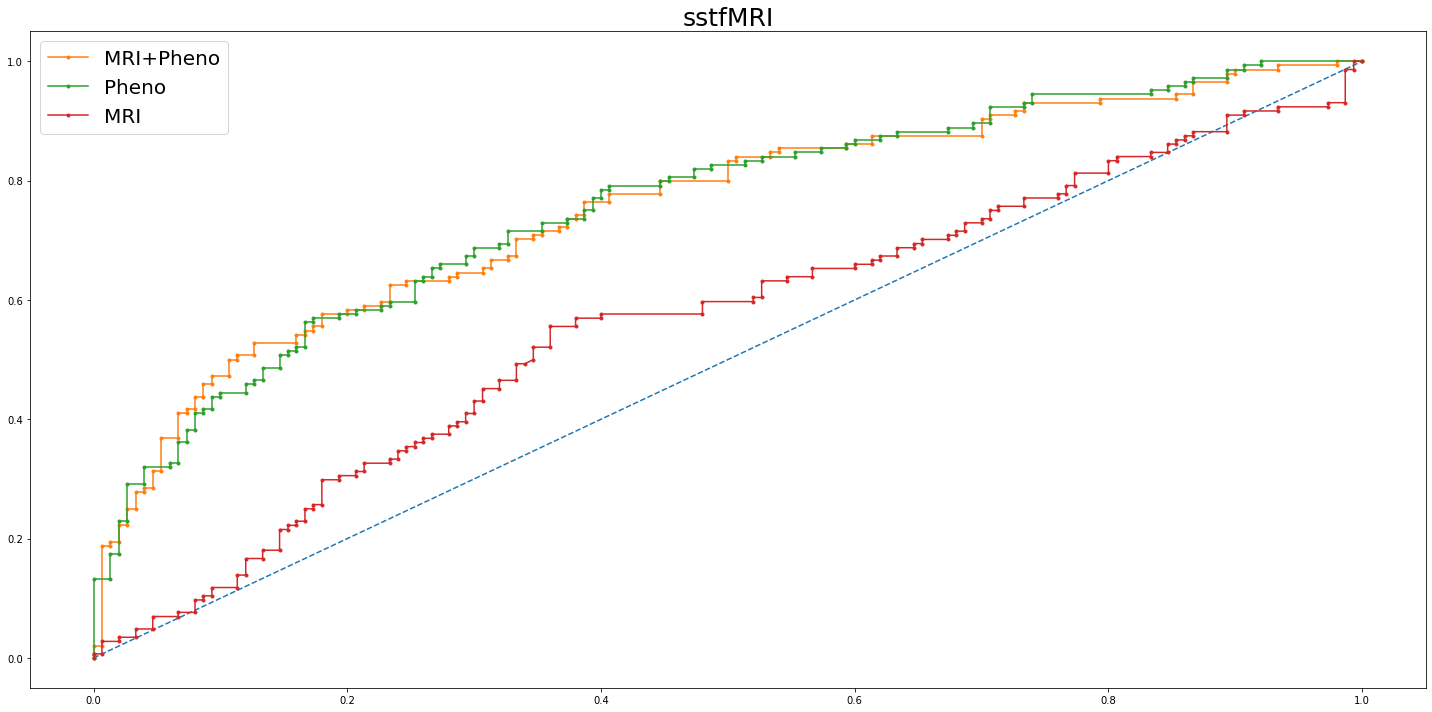

In [20]:
test_auc_all, test_auc_pheno, test_auc_mri, import_feat_all, import_feat_pheno, import_feat_mri, Y_test_all , preds_prob_all, Y_test_pheno , preds_prob_pheno, Y_test_mri , preds_prob_mri, Y_valid_all, preds_val_prob_all, Y_valid_pheno, preds_val_prob_pheno, Y_valid_mri, preds_val_prob_mri= hyperparametertuning_CV (train_data, test_data, target, unused_feat, Num_FOLDS, Num_feat)
    

In [21]:
valid_auc_all = roc_auc_score (Y_valid_all, preds_val_prob_all[:,1])
valid_auc_pheno = roc_auc_score (Y_valid_pheno, preds_val_prob_pheno[:,1])
valid_auc_mri = roc_auc_score (Y_valid_mri, preds_val_prob_mri[:,1])

In [22]:
print(dataset_name)
print("")
print("Test AUC")
print(f"Pheno+MRI:{round((test_auc_all)*100,2)}%")
print( f"Pheno:{round((test_auc_pheno),4)*100}%")
print(f"MRI:{round((test_auc_mri)*100,2)}%")
print("")
    
print("Valid AUC")

print( f"Pheno+MRI:{round(valid_auc_all,4)*100}%")
print( f"Pheno:{round(valid_auc_pheno*100,2)}%")
print( f"MRI:{round(valid_auc_mri,4)*100}%")

sstfMRI

Test AUC
Pheno+MRI:75.44%
Pheno:75.68%
MRI:56.1%

Valid AUC
Pheno+MRI:77.42%
Pheno:77.69%
MRI:56.03%


In [23]:
import_feat_every=pd.concat([import_feat_all,import_feat_pheno, import_feat_mri])

import_feat_every.to_csv(f"{dataset_name}_features.csv")

import_feat_every 


,feature name,ratio
0,tfmri_sst_all_incorrect.stop.vs.correct.go_bet...,0.116355
1,TotProb.CBCL,0.114498
2,PPSP_frequency,0.114218
3,AnxDep.CBCL,0.099873
4,tfmri_sst_all_incorrect.go.vs.correct.go_beta_...,0.055488
5,tfmri_sst_all_correct.go.vs.fixation_beta_cort...,0.036886
6,tfmri_sst_all_incorrect.stop.vs.correct.go_bet...,0.034752
7,Social.CBCL,0.033503
8,tfmri_sst_all_correct.stop.vs.incorrect.stop_b...,0.032660
9,tfmri_sst_all_correct.stop.vs.incorrect.stop_b...,0.031931
